In [56]:
import os 
import sys
import re
from collections import defaultdict
import matplotlib.pyplot as plt

In [57]:
FP = "../logs/"
FNAME_CAP = r"\.\.\/logs\/(\w*.jl).*"
MEM_START = r"\s*(\d*)"
LINE_CAP = r"\s*\d*\w*\s*(.*)"

# overriden int with built in exception 
def exc_int(s: str) -> int:
    try:
        return int(s)
    except ValueError:
        return 0

# {file_path: ([line ; mem usage])}
mem_record = defaultdict(list)

def process_mem_file(fp: str) -> None:
    with open(fp, "r") as f:
        fp = re.search(FNAME_CAP, fp).group(1)
        for line_n, line in enumerate(f):
            mem_usage = re.search(MEM_START, line)
            if exc_int(mem_usage.group(1)) > 0:
                line = re.search(LINE_CAP, line).group(1)
                mem_record[fp].append((line_n + 1, mem_usage.group(1), line))

for f in os.listdir(FP):
    if f.endswith(".mem"):
        process_mem_file(FP + f)

In [58]:
def find_max_mem_usage() -> None:
    max_mem = 0
    max_mem_fp = ""
    max_mem_line = 0
    for fp, mem_usage in mem_record.items():
        for line_n, mem, _ in mem_usage:
            if exc_int(mem) > max_mem:
                max_mem = exc_int(mem)
                max_mem_fp = fp
                max_mem_line = line_n
    print(f"Max memory usage: {bytes_to_gb(max_mem)} GB in {max_mem_fp} @ L{max_mem_line}")
    
def bytes_to_gb(b: int) -> float:
    return b / 1024 / 1024 / 1024
    
find_max_mem_usage()

Max memory usage: 8.03495767712593 GB in bvh.jl @ L66


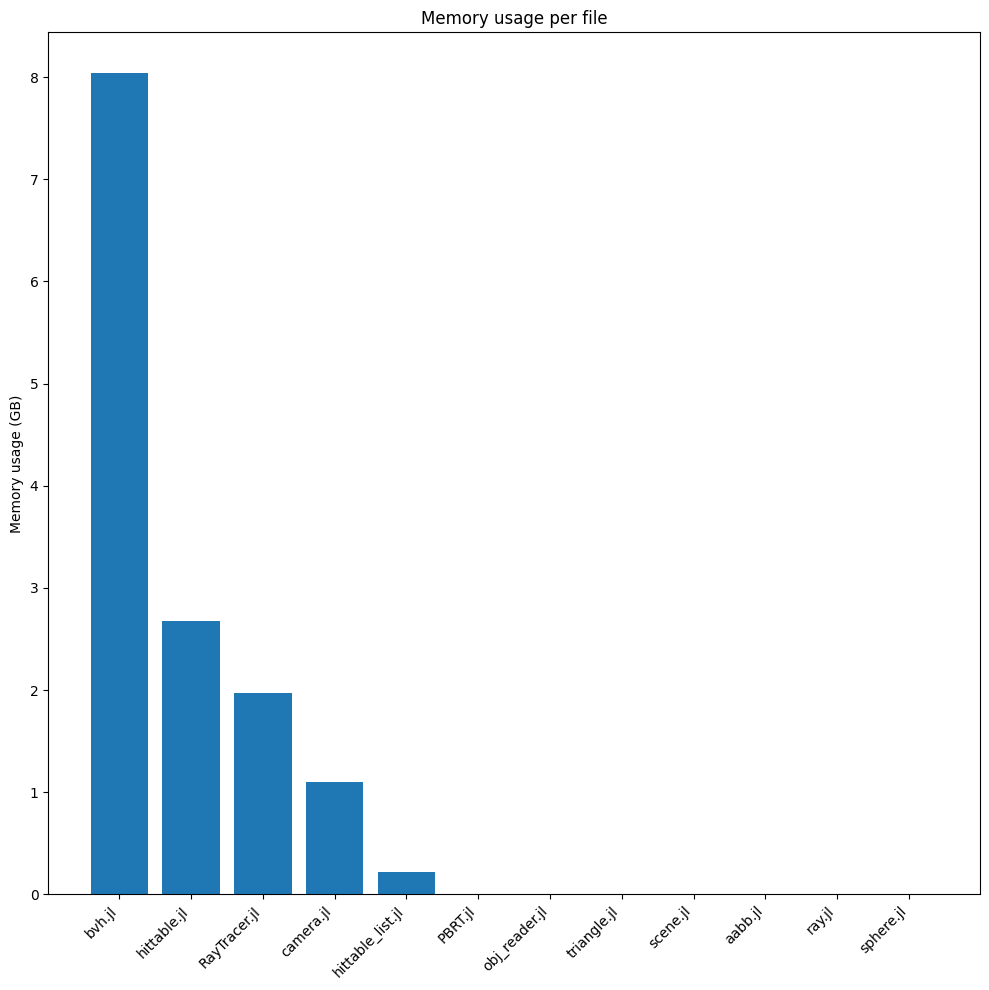

In [63]:
# aggregate total memory usage for each file 
mem_usage = {}
for fp, mem in mem_record.items():
    mem_usage[fp] = sum([exc_int(m) for _, m, _ in mem])
    
# sort by memory usage
mem_usage = dict(sorted(mem_usage.items(), key=lambda item: item[1], reverse=True))

# plot memory usage
plt.figure(figsize=(10, 10))
plt.bar(mem_usage.keys(), [bytes_to_gb(v) for v in mem_usage.values()])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Memory usage (GB)")
plt.title("Memory usage per file")

# increase dpi of plot 
plt.tight_layout()
plt.savefig("mem_usage.png", dpi=200)
plt.show()

In [61]:
max_mem_file = list(mem_usage.keys())[0]
sorted_lines = sorted(mem_record[max_mem_file], key=lambda x: exc_int(x[1]), reverse=True)
print(
    f"max mem file: {max_mem_file}\n" + 
    f"max mem usage: {bytes_to_gb(mem_usage[max_mem_file])} GB\n" + 
    "\n".join([f"L{line_n}: {exc_int(mem)} bytes ; {line.strip("\n").strip()}" for line_n, mem, line in sorted_lines])
)

max mem file: bvh.jl
max mem usage: 8.035757809877396 GB
L66: 8627470112 bytes ; hit_right = hit!(node.right, r, interval(ray_t.lo, ifelse(hit_left, rec.t, ray_t.hi)), rec)
L23: 616064 bytes ; bbox = aabb(bbox, objects[i].bbox)
L21: 98112 bytes ; bbox = aabb()
L47: 47008 bytes ; objects[start:end_] = sort(objects[start:end_], lt=comparator)
L50: 40800 bytes ; node.left = bvh_node(objects, start, mid, bvh_node())
L51: 40800 bytes ; node.right = bvh_node(objects, mid, end_, bvh_node())
L52: 8160 bytes ; bvh_node(node.left, node.right, bbox)
L45: 7104 bytes ; bvh_node(node.left, node.right, bbox)
L41: 1088 bytes ; bvh_node(node.left, node.right, bbox)
